In [1]:
%matplotlib inline

In [191]:
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.stats import *
import os
import math
from IPython.display import HTML
from IPython.display import Video

from scipy.signal import deconvolve
import pomegranate
from pomegranate import *

import json


In [120]:
def create_burst_trace(
        kon,
        koff,
        duration,
        polymerase_loading_rate,
        polymerase_transit_time,
    ):
    
    on_exp = expon(loc=0,scale=1/kon)
    off_exp = expon(loc=0,scale=1/koff)
    
    output = np.zeros((3,duration))
    time = 0
    promoter_state = 0
    
    while time < duration:
        
        if promoter_state == 0:
            off_interval = on_exp.rvs()
            
            promoter_state = 1
            time += off_interval

        else:
            on_interval = off_exp.rvs()
            tsm = math.modf(time)
            tem = math.modf(time + on_interval)
            
            if tsm[0] <= .5:
                t_start = tsm[1]
            else:
                t_start = tsm[1] + 1    
            if tem[0] >= .5:
                t_end = tem[1] + 1
            else:
                t_end = tem[1]
            t_end = np.min([t_end,duration])
            
            np.put(output[0],np.arange(int(t_start),int(t_end)),1)
            
            time += on_interval
            promoter_state = 0
            
    cv = np.convolve(output[0],polymerase_loading_rate * np.ones(polymerase_transit_time))
    output[1] = cv[0:duration]
    output[2] = output[1] + norm.rvs(loc=0,scale=.5,size=duration)
    return output

def create_burst_traces(
    kon = 1/40,
    koff = 1/20,
    duration = 1000,
    polymerase_loading_rate = .2,
    polymerase_transit_time = 30,
    n = 100
    ):

    output = []
    
    for i in range(0,n):
        output.append(
            create_burst_trace(
                kon=kon,
                koff=koff,
                duration=duration,
                polymerase_loading_rate=polymerase_loading_rate,
                polymerase_transit_time=polymerase_transit_time            
            ))
    
    return np.array(output)
    

In [121]:
kon = 1/40
koff = 1/20
duration = 1000
polymerase_loading_rate = .2
polymerase_transit_time = 30

bursts = create_burst_traces(
    kon=kon,
    koff=koff,
    duration=duration,
    polymerase_loading_rate=polymerase_loading_rate,
    polymerase_transit_time=polymerase_transit_time      
)

In [122]:
bursts.shape

(100, 3, 1000)

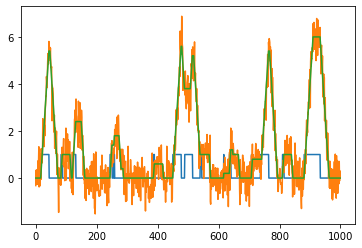

In [123]:
plt.plot(bursts[10][0])
plt.plot(bursts[10][2])
plt.plot(bursts[10][1])

In [124]:
burst = bursts[10]

In [125]:
l = len(burst[0])

basis = np.zeros((l,l))

for i in range(0,l):
    np.put(
        basis[i],
        np.arange(i,min(i+polymerase_transit_time,l)),
        1)

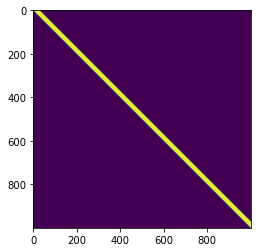

In [126]:
plt.imshow(basis)

In [131]:
poly_nnls = np.convolve(scipy.optimize.nnls(basis.T,burst[2])[0] / polymerase_loading_rate,np.ones(5)/5)[0:duration]

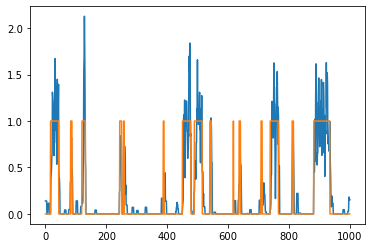

In [135]:
plt.plot(poly_nnls)
plt.plot(bursts[10][0])

In [136]:
d_off = NormalDistribution(0,.25)
d_on = NormalDistribution(1,.25)

s_off = State(d_off, name="OFF")
s_on = State(d_on, name="ON")

hmm = HiddenMarkovModel()
hmm.add_states(s_off, s_on)
hmm.add_transition( hmm.start, s_off, 1.0 )
hmm.add_transition( hmm.start, s_on, 0 )
hmm.add_transition( s_off, s_off, 1-kon )
hmm.add_transition( s_off, s_on, kon )
hmm.add_transition( s_on, s_on, 1-koff )
hmm.add_transition( s_on, s_off, koff)
hmm.bake()

In [137]:
hmm_out = hmm.predict(poly_nnls, algorithm='viterbi')

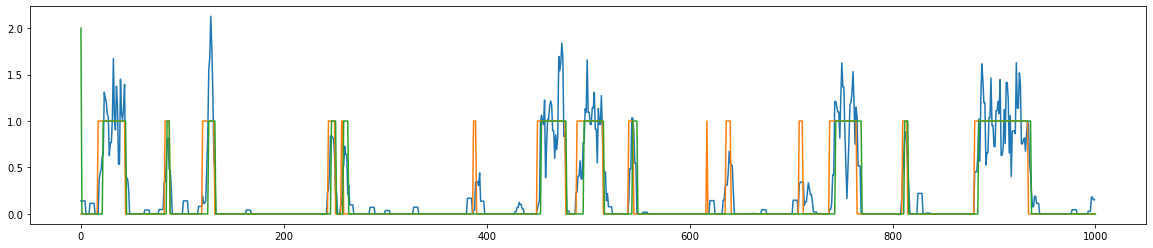

In [139]:
plt.figure(figsize=(20,4))
plt.plot(poly_nnls)
plt.plot(bursts[10][0])
plt.plot(hmm_out)

In [147]:
poly_nnls = np.zeros((len(bursts),duration))

for i,burst in enumerate(bursts):
    poly_nnls[i] = np.convolve(scipy.optimize.nnls(basis.T,burst[2])[0] / polymerase_loading_rate,np.ones(5)/5)[0:duration]

In [204]:
kon = 1/40
koff = 1/20

kon = 1/100
koff = 1/100

d_off = NormalDistribution(0,.25)
d_on = NormalDistribution(1,.25)

s_off = State(d_off, name="OFF")
s_on = State(d_on, name="ON")

hmm = HiddenMarkovModel()
hmm.add_states(s_off, s_on)
hmm.add_transition( hmm.start, s_off, 1.0 )
hmm.add_transition( hmm.start, s_on, 0 )
hmm.add_transition( s_off, s_off, 1-kon )
hmm.add_transition( s_off, s_on, kon )
hmm.add_transition( s_on, s_on, 1-koff )
hmm.add_transition( s_on, s_off, koff)
hmm.bake()

hmm_dict = json.loads(hmm.to_json())

In [205]:
hmm_out = np.zeros((len(bursts),duration))

for i, burst in enumerate(bursts):
    hmm_out[i] = hmm.predict(poly_nnls[i], algorithm='viterbi')[1:]

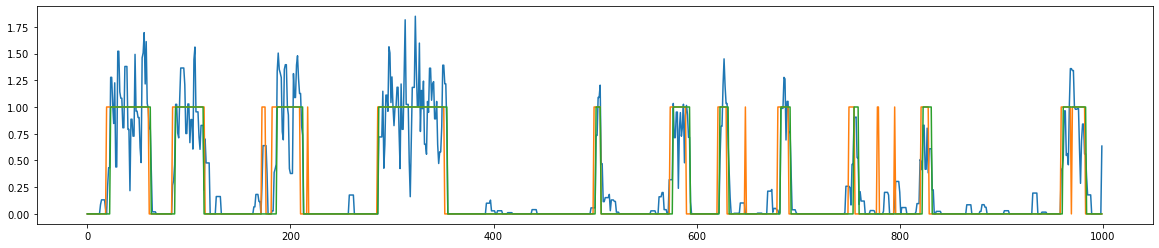

In [206]:
i = 5

plt.figure(figsize=(20,4))
plt.plot(poly_nnls[i])
plt.plot(bursts[i][0])
plt.plot(hmm_out[i])

In [207]:
hmm_fit = hmm.fit(poly_nnls,algorithm='baum-welch')

In [208]:
hmm_fit_dict = json.loads(hmm.to_json())

In [209]:
hmm_dict['edges']

[[2, 0, 1.0, 1.0, None],
 [2, 1, 0.0, 0, None],
 [0, 0, 0.99, 0.99, None],
 [0, 1, 0.010000000000000007, 0.01, None],
 [1, 1, 0.99, 0.99, None],
 [1, 0, 0.010000000000000007, 0.01, None]]

In [210]:
hmm_fit_dict['edges']

[[2, 0, 1.0, 1.0, None],
 [2, 1, 0.0, 0, None],
 [0, 0, 0.9350059750822182, 0.99, None],
 [0, 1, 0.06499402491778179, 0.01, None],
 [1, 1, 0.9407594581113505, 0.99, None],
 [1, 0, 0.059240541888649426, 0.01, None]]

In [211]:
hmm_fit_out = np.zeros((len(bursts),duration))

for i, burst in enumerate(bursts):
    hmm_fit_out[i] = hmm.predict(poly_nnls[i], algorithm='viterbi')[1:]